<a href="https://colab.research.google.com/github/LoznianuAnamaria/challenges/blob/main/Crypto%20Market%20-%20Impact%20of%20Google%20Trends/Google_Trends-%3E_Crypto_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install prophet
!pip install tensorflow

In [55]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.mode.chained_assignment = None

# Data loading & preparation

In [56]:
trends_directory = 'trends'
csv_files = [f for f in os.listdir(trends_directory) if f.endswith('.csv')]

# Load each CSV file into a DataFrame, process it, and store them in a list
data_frames = []
for filename in csv_files:
    filepath = os.path.join(trends_directory, filename)
    # Read the CSV, adjusting to skip the first unwanted row and set the correct header
    df = pd.read_csv(filepath, skiprows=1)
    # Set the first row as header
    new_header = df.iloc[0]  # Grab the first row for the header
    df = df[1:]  # Take the data less the header row
    df.columns = new_header  # Set the header row as the df header
    # Rename columns to a standard format
    df.columns = ['week', filename.split('.')[0]]
    df.set_index('week', inplace=True)
    data_frames.append(df)

# Combine all the DataFrame objects into a single DataFrame by joining on index (week)
trends = pd.concat(data_frames, axis=1)

trends.reset_index(inplace=True)

trends['week'] = pd.to_datetime(trends['week'])

# Convert all columns except 'week' to numeric, coercing errors (turning non-convertible strings to NaN)
for column in trends.columns:
    if column != 'week':
        trends[column] = pd.to_numeric(trends[column], errors='coerce')

# Converting values "<1" to numeric 0 values
for col in trends.columns:
    if trends[col].dtype == 'object':
        trends[col] = trends[col].str.replace('<1', '0').astype(int)

# Replace NaNs with 0
trends.fillna(0, inplace=True)

trends.to_csv('trends.csv', index=False)
trends.head()

,week,XRP,dogecoin,kucoin,fetch,ethereum,bitcoin,filecoin,monero,tezos,...,cardano,singularitynet,uniswap,litecoin,pancakeswap,polkadot,ocean protocol,solana,bnb,oasis network
0,2019-04-14,6,0.0,3,5,3,11,1.0,22,15,...,4,8,0.0,16,0.0,6,13,9,60,5
1,2019-04-21,5,0.0,3,0,3,12,1.0,21,11,...,3,15,0.0,15,0.0,6,14,8,57,4
2,2019-04-28,6,0.0,3,4,3,11,1.0,23,8,...,3,10,0.0,15,0.0,6,32,8,53,2
3,2019-05-05,6,0.0,3,0,3,14,1.0,23,8,...,3,0,0.0,17,0.0,6,22,8,54,3
4,2019-05-12,14,1.0,7,0,7,23,1.0,29,13,...,5,9,0.0,26,0.0,6,10,9,56,5


# Prices data preparation

In [57]:
prices_directory = 'prices/'
prices_files = [f for f in os.listdir(prices_directory) if f.endswith('.csv')]

prices = pd.DataFrame()

# Loop through each file, read it into a DataFrame, add a 'Symbol' column, and append it to the combined DataFrame
for filename in prices_files:
    filepath = os.path.join(prices_directory, filename)

    symbol = os.path.basename(filepath).split('-')[0]
    df = pd.read_csv(filepath)
    df['Symbol'] = symbol  # Add the cryptocurrency symbol as a new column
    prices = pd.concat([prices, df], ignore_index=True)

# Save the combined DataFrame to a new CSV file
prices.to_csv('prices.csv', index=False)
prices.head()

""


# Exploratory data analysis

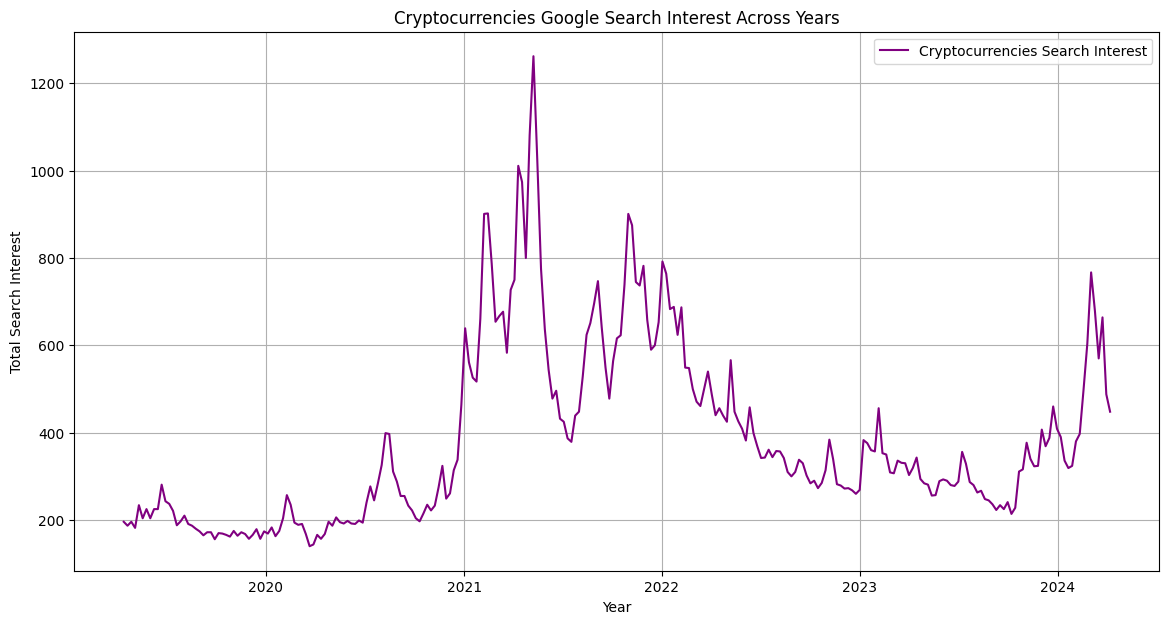

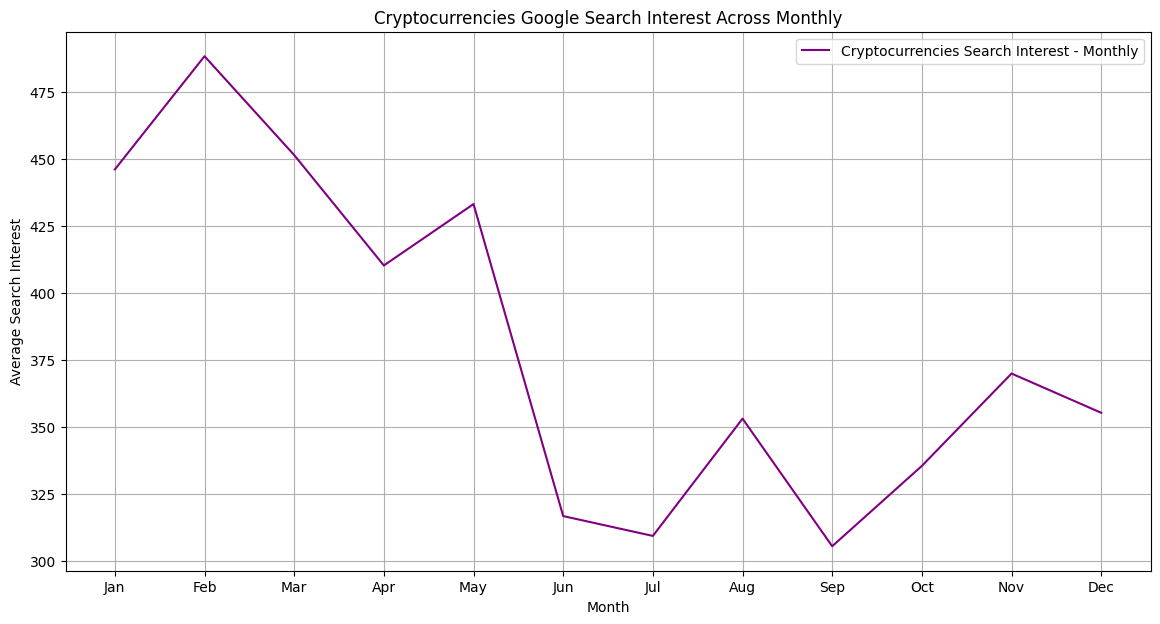

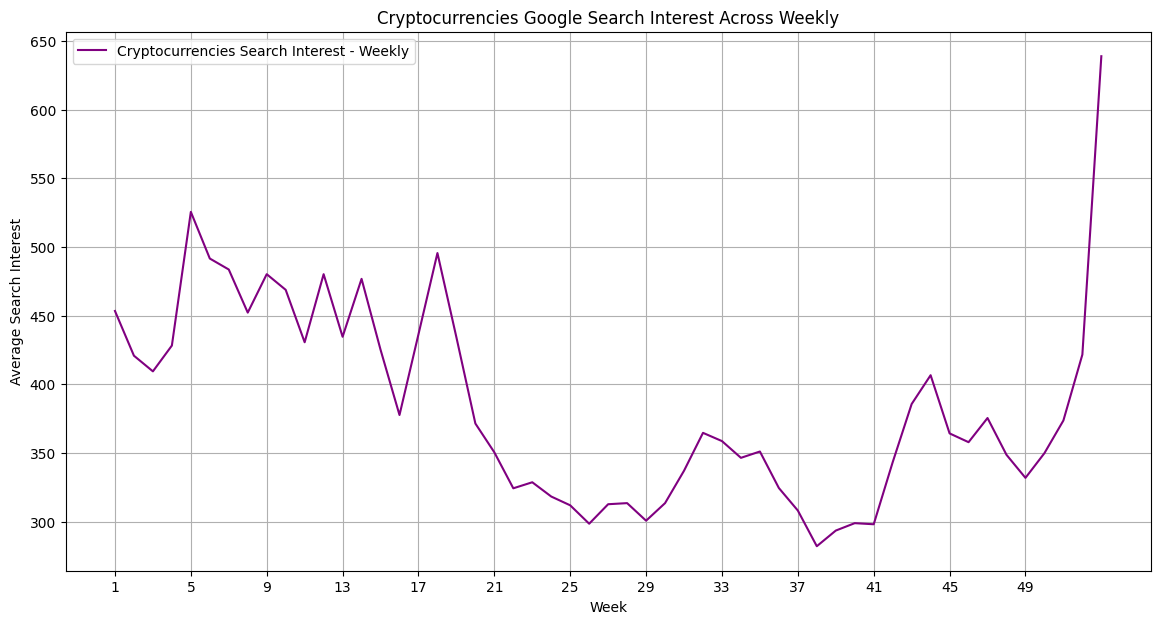

In [58]:
# Summing up all search interests for a combined trend line
general_trends = trends.copy()
general_trends['Month'] = general_trends['week'].dt.month
general_trends['Total Search Interest'] = general_trends.drop('week', axis=1).sum(axis=1)
general_trends['Week of Year'] = general_trends['week'].dt.isocalendar().week

monthly_average = general_trends.groupby('Month')['Total Search Interest'].mean()
weekly_average = general_trends.groupby('Week of Year')['Total Search Interest'].mean()

# Plotting the general search interest over time
plt.figure(figsize=(14, 7))
plt.plot(general_trends['week'], general_trends['Total Search Interest'], label='Cryptocurrencies Search Interest', color='purple')

plt.title('Cryptocurrencies Google Search Interest Across Years')
plt.xlabel('Year')
plt.ylabel('Total Search Interest')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the monthly averages
plt.figure(figsize=(14, 7))
plt.plot(monthly_average.index, monthly_average, label='Cryptocurrencies Search Interest - Monthly', color='purple')
plt.xticks(monthly_average.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Cryptocurrencies Google Search Interest Across Monthly')
plt.xlabel('Month')
plt.ylabel('Average Search Interest')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the weekly averages
plt.figure(figsize=(14, 7))
plt.plot(weekly_average.index, weekly_average, label='Cryptocurrencies Search Interest - Weekly', color='purple')
plt.xticks(range(1, 53, 4), range(1, 53, 4))  # Showing every 4 weeks for clarity

plt.title('Cryptocurrencies Google Search Interest Across Weekly')
plt.xlabel('Week')
plt.ylabel('Average Search Interest')
plt.legend()
plt.grid(True)
plt.show()

#  Trends years insights


Year with the Highest Interest:
year                     2021-01-01 00:00:00
Total Search Interest                35145.0
Name: 2, dtype: object

Year with the Lowest Interest:
year                     2024-01-01 00:00:00
Total Search Interest                 6864.0
Name: 5, dtype: object


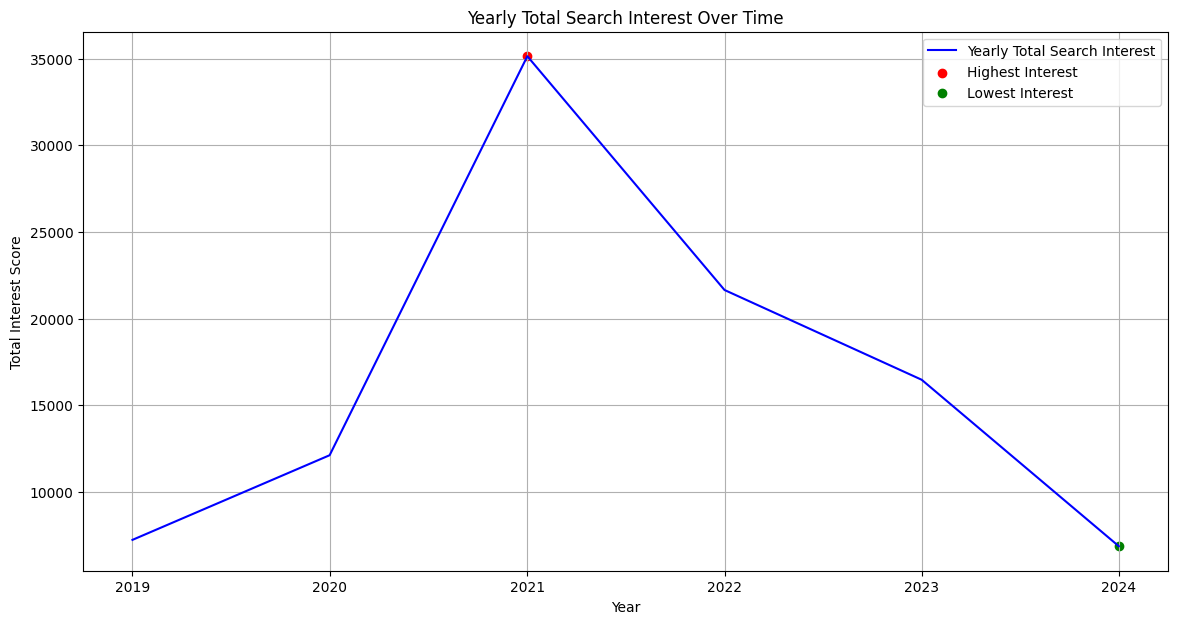

In [59]:
# Group data by year and sum the total interest
general_trends['year'] = general_trends['week'].dt.to_period('Y')
yearly_data = general_trends.groupby('year')['Total Search Interest'].sum().reset_index()
yearly_data['year'] = yearly_data['year'].dt.to_timestamp()

# Identify the year with the highest and lowest search interest
max_interest_year = yearly_data.loc[yearly_data['Total Search Interest'].idxmax()]
min_interest_year = yearly_data.loc[yearly_data['Total Search Interest'].idxmin()]

print("Year with the Highest Interest:")
print(max_interest_year)
print("\nYear with the Lowest Interest:")
print(min_interest_year)

# Plotting the total search interest over time by year
plt.figure(figsize=(14, 7))
plt.plot(yearly_data['year'], yearly_data['Total Search Interest'], label='Yearly Total Search Interest', color='blue')
plt.scatter(max_interest_year['year'], max_interest_year['Total Search Interest'], color='red', label='Highest Interest')
plt.scatter(min_interest_year['year'], min_interest_year['Total Search Interest'], color='green', label='Lowest Interest')
plt.title('Yearly Total Search Interest Over Time')
plt.xlabel('Year')
plt.ylabel('Total Interest Score')
plt.legend()
plt.grid(True)
plt.show()


# Trends months insights

Month with the Highest Interest:
month                    2021-05-01 00:00:00
Total Search Interest                 4782.0
Name: 25, dtype: object

Month with the Lowest Interest:
month                    2024-04-01 00:00:00
Total Search Interest                  448.0
Name: 60, dtype: object


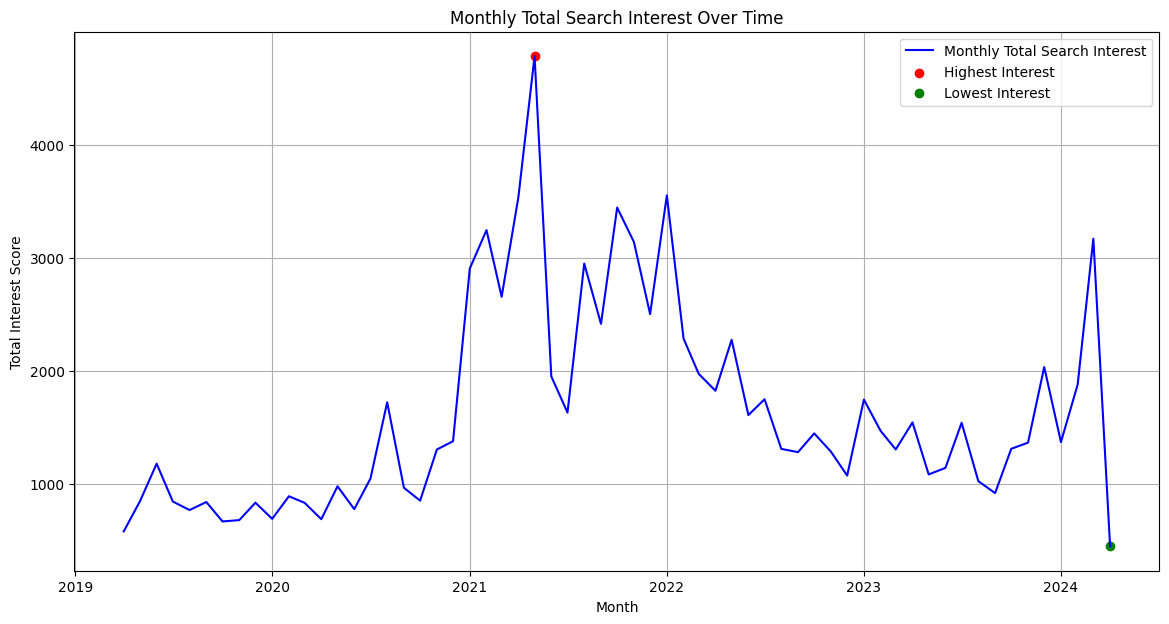

In [60]:
# Group data by month and sum the total interest
general_trends['month'] = general_trends['week'].dt.to_period('M')
monthly_data = general_trends.groupby('month')['Total Search Interest'].sum().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Identify the month with the highest and lowest search interest
max_interest_month = monthly_data.loc[monthly_data['Total Search Interest'].idxmax()]
min_interest_month = monthly_data.loc[monthly_data['Total Search Interest'].idxmin()]

print("Month with the Highest Interest:")
print(max_interest_month)
print("\nMonth with the Lowest Interest:")
print(min_interest_month)

# Plotting the total search interest over time by month
plt.figure(figsize=(14, 7))
plt.plot(monthly_data['month'], monthly_data['Total Search Interest'], label='Monthly Total Search Interest', color='blue')
plt.scatter(max_interest_month['month'], max_interest_month['Total Search Interest'], color='red', label='Highest Interest')
plt.scatter(min_interest_month['month'], min_interest_month['Total Search Interest'], color='green', label='Lowest Interest')
plt.title('Monthly Total Search Interest Over Time')
plt.xlabel('Month')
plt.ylabel('Total Interest Score')
plt.legend()
plt.grid(True)
plt.show()


# Trends weeks insights

Week with the Highest Search Interest
* Date: May 9, 2021
* Total Interest: 933
* Key Cryptocurrencies:
** BNB, Cardano, Ethereum, Uniswap, Pancakeswap, Dogecoin: 100 each
** Bitcoin, Chainlink: 58 each
** Litecoin, Monero: 90 and 91 respectively


Week with the Lowest Search Interest
* Date: March 22, 2020
* Total Interest: 137
* Most active cryptocurrencies had significantly lower scores compared to the peak:
** Bitcoin: 18
** Ethereum: 4
** Litecoin, Monero: 14 and 22 respectively

Week with the Highest Interest:
week                     2021-05-09 00:00:00
XRP                                       48
dogecoin                               100.0
kucoin                                    83
fetch                                      5
ethereum                                 100
bitcoin                                   58
filecoin                                24.0
monero                                    91
tezos                                     42
chainlink                                 58
cardano                                  100
singularitynet                            19
uniswap                                100.0
litecoin                                  90
pancakeswap                            100.0
polkadot                                  62
ocean protocol                            52
solana                                    19
bnb                                      100
oasis network                              6
Month                  

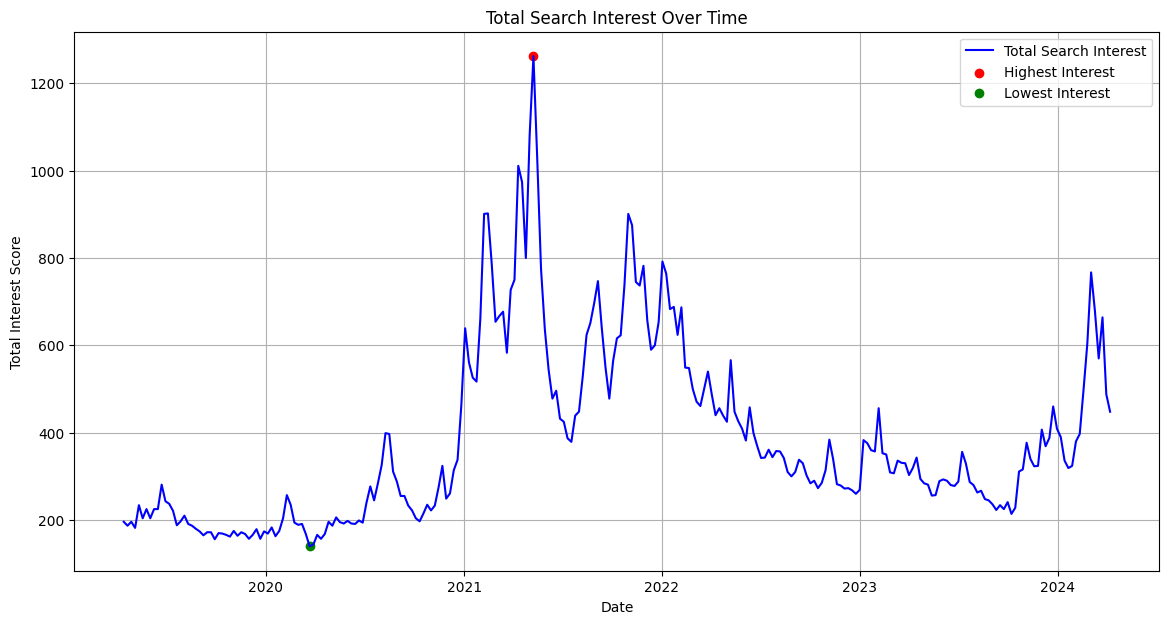

In [61]:
# Identify the week with the highest and lowest search interest
max_interest_details = general_trends.loc[general_trends['Total Search Interest'].idxmax()]
min_interest_details = general_trends.loc[general_trends['Total Search Interest'].idxmin()]

print("Week with the Highest Interest:")
print(max_interest_details)
print("\nWeek with the Lowest Interest:")
print(min_interest_details)

# Plotting the total search interest over time
plt.figure(figsize=(14, 7))
plt.plot(general_trends['week'], general_trends['Total Search Interest'], label='Total Search Interest', color='blue')
plt.scatter(max_interest_details['week'], max_interest_details['Total Search Interest'], color='red', label='Highest Interest')
plt.scatter(min_interest_details['week'], min_interest_details['Total Search Interest'], color='green', label='Lowest Interest')
plt.title('Total Search Interest Over Time')
plt.xlabel('Date')
plt.ylabel('Total Interest Score')
plt.legend()
plt.grid(True)
plt.show()

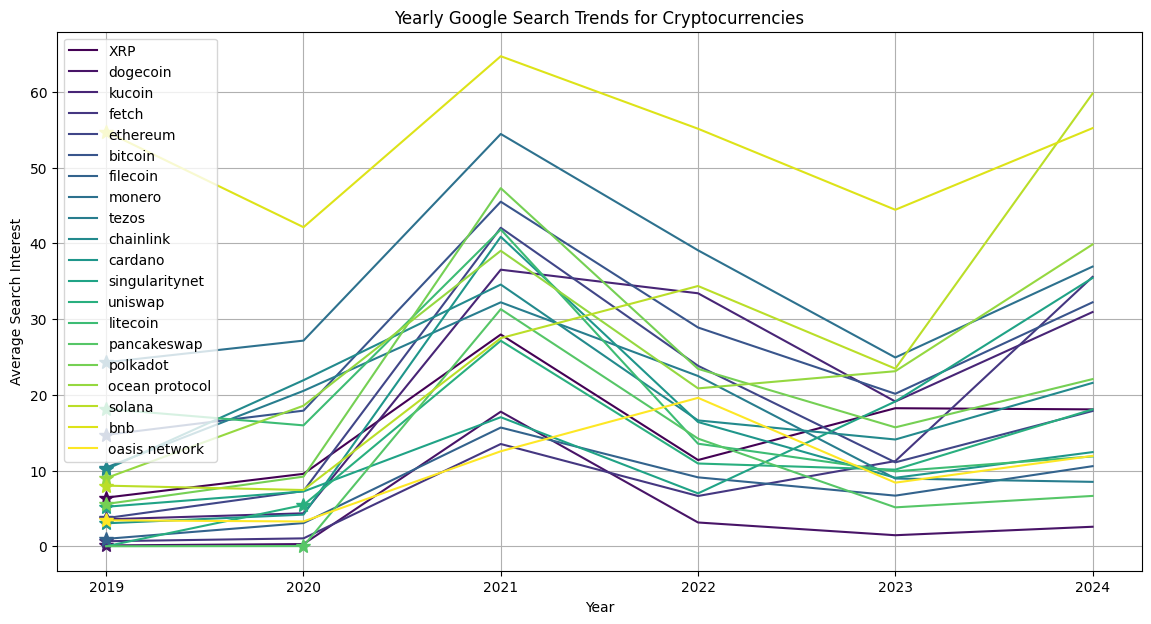

In [63]:
# Yearly trend resampling
yearly_trends = trends.resample('Y', on='week').mean()

# Selecting a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(yearly_trends.columns)))

# Plotting Yearly Trends
plt.figure(figsize=(14, 7))
for idx, column in enumerate(yearly_trends.columns):
    if column != 'week':
        # Plot the yearly trend
        plt.plot(yearly_trends.index.year, yearly_trends[column], label=column, color=colors[idx])

        # Find the first year where the search interest is greater than zero and mark it
        first_non_zero_year = yearly_trends[column].gt(0).idxmax().year
        first_non_zero_value = yearly_trends.loc[yearly_trends[column].gt(0).idxmax(), column]
        plt.plot(first_non_zero_year, first_non_zero_value, '*', color=colors[idx], markersize=10)

plt.title('Yearly Google Search Trends for Cryptocurrencies')
plt.xlabel('Year')
plt.ylabel('Average Search Interest')
plt.legend()
plt.grid(True)
plt.show()

# Evolution of specific coins

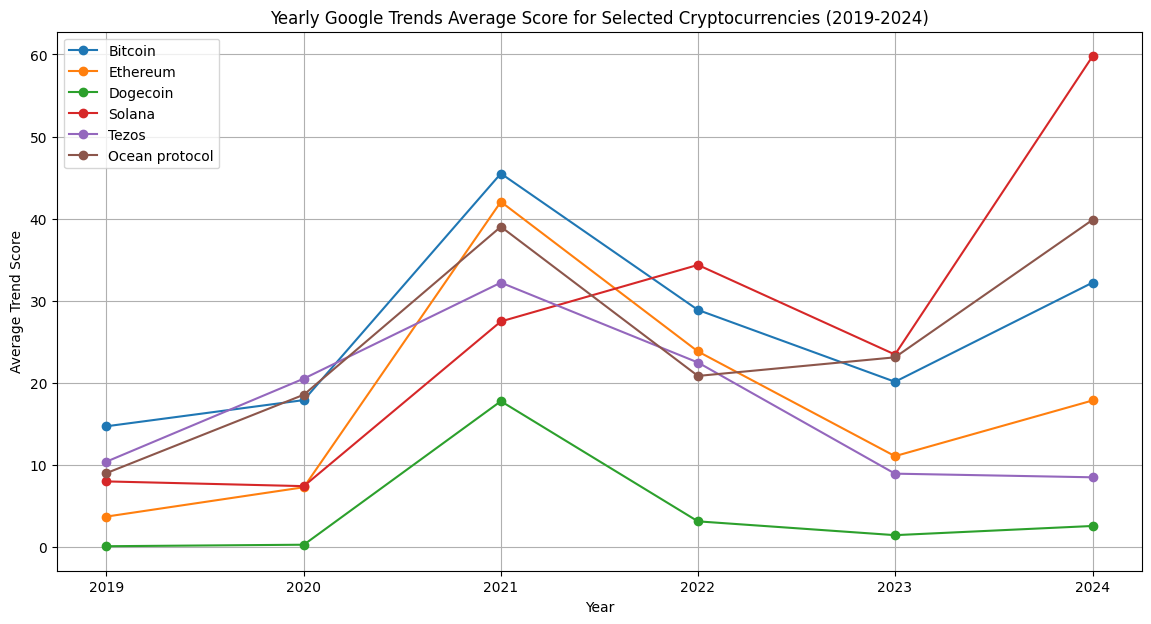

In [80]:
cryptos_to_plot = ['bitcoin', 'ethereum', 'dogecoin', 'solana', 'tezos', 'ocean protocol']
yearly_trends.head()

# Plotting
plt.figure(figsize=(14, 7))
for crypto in cryptos_to_plot:
    plt.plot(yearly_trends.index, yearly_trends[crypto], label=crypto.capitalize(), marker='o')

plt.title('Yearly Google Trends Average Score for Selected Cryptocurrencies (2019-2024)')
plt.xlabel('Year')
plt.ylabel('Average Trend Score')
plt.xticks(yearly_trends.index, yearly_trends.index.year)  # Set x-axis ticks to display only years
plt.legend()
plt.grid(True)
plt.show()

# 2024 Interests

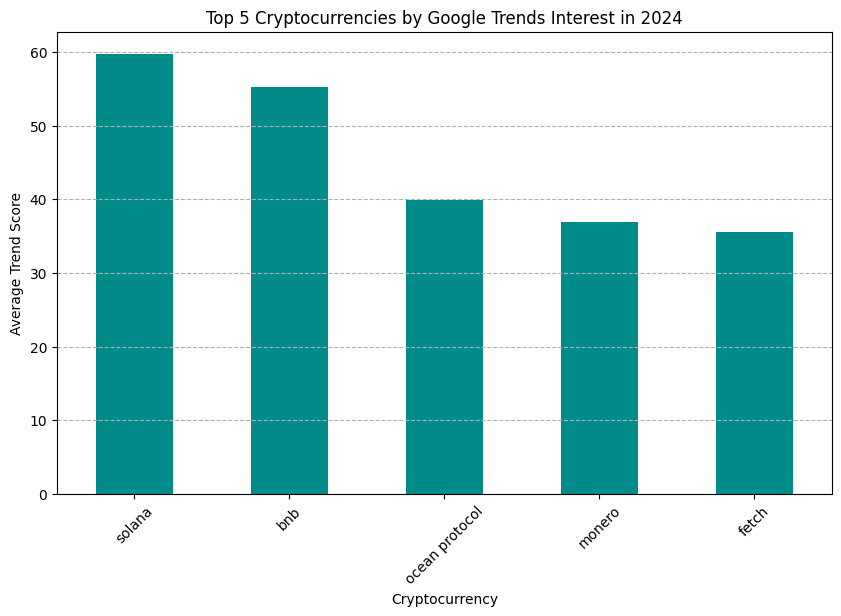

In [ ]:
file_path = 'trends.csv'
data = pd.read_csv(file_path)


data['week'] = pd.to_datetime(data['week'])
data['year'] = data['week'].dt.year.astype(int)
analysis_data = data.drop('week', axis=1)

float_cols = analysis_data.select_dtypes(include=['float64']).columns
analysis_data[float_cols] = analysis_data[float_cols].fillna(0).astype(int)

# Aggregate data by year
yearly_trends = analysis_data.groupby('year').mean()

# Select data for 2024 and find the top 5 cryptocurrencies
interest_2024 = yearly_trends.loc[2024]
top_interest_2024 = interest_2024.sort_values(ascending=False).head(5)

# Plot the top 5 cryptocurrencies
plt.figure(figsize=(10, 6))
top_interest_2024.plot(kind='bar', color='darkcyan')
plt.title('Top 5 Cryptocurrencies by Google Trends Interest in 2024')
plt.xlabel('Cryptocurrency')
plt.ylabel('Average Trend Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


# Ocean Protocol Trend

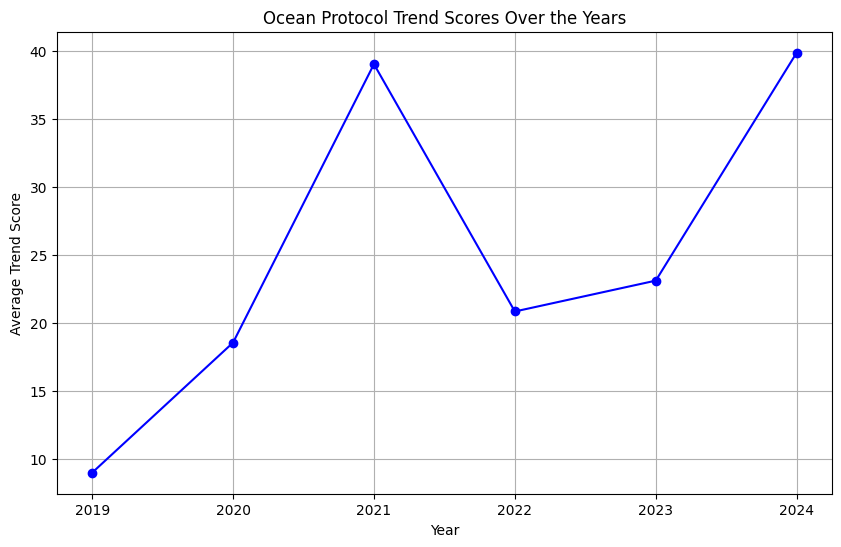

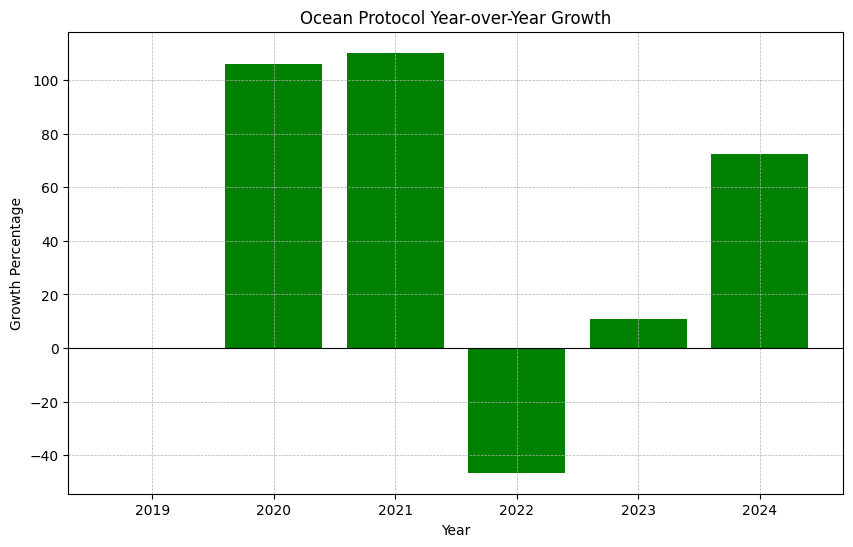

In [ ]:
# Select the data for Ocean Protocol
ocean_protocol_trends = yearly_trends['ocean protocol']

# Calculate the year-over-year percentage change
ocean_protocol_growth = ocean_protocol_trends.pct_change() * 100

# Create a DataFrame to store the trend scores and growth percentages
ocean_protocol_insights = pd.DataFrame({
    'Average Trend Score': ocean_protocol_trends,
    'Year-over-Year Growth (%)': ocean_protocol_growth
})

ocean_protocol_insights.fillna(0, inplace=True)

# Plotting the trend scores over the years
plt.figure(figsize=(10, 6))
plt.plot(ocean_protocol_insights['Average Trend Score'], marker='o', linestyle='-', color='b')
plt.title('Ocean Protocol Trend Scores Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Trend Score')
plt.grid(True)
plt.show()

# Plotting the year-over-year growth percentages
plt.figure(figsize=(10, 6))
plt.bar(ocean_protocol_insights.index, ocean_protocol_insights['Year-over-Year Growth (%)'], color='g')
plt.title('Ocean Protocol Year-over-Year Growth')
plt.xlabel('Year')
plt.ylabel('Growth Percentage')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.8)
plt.show()


# Trends Seasonality

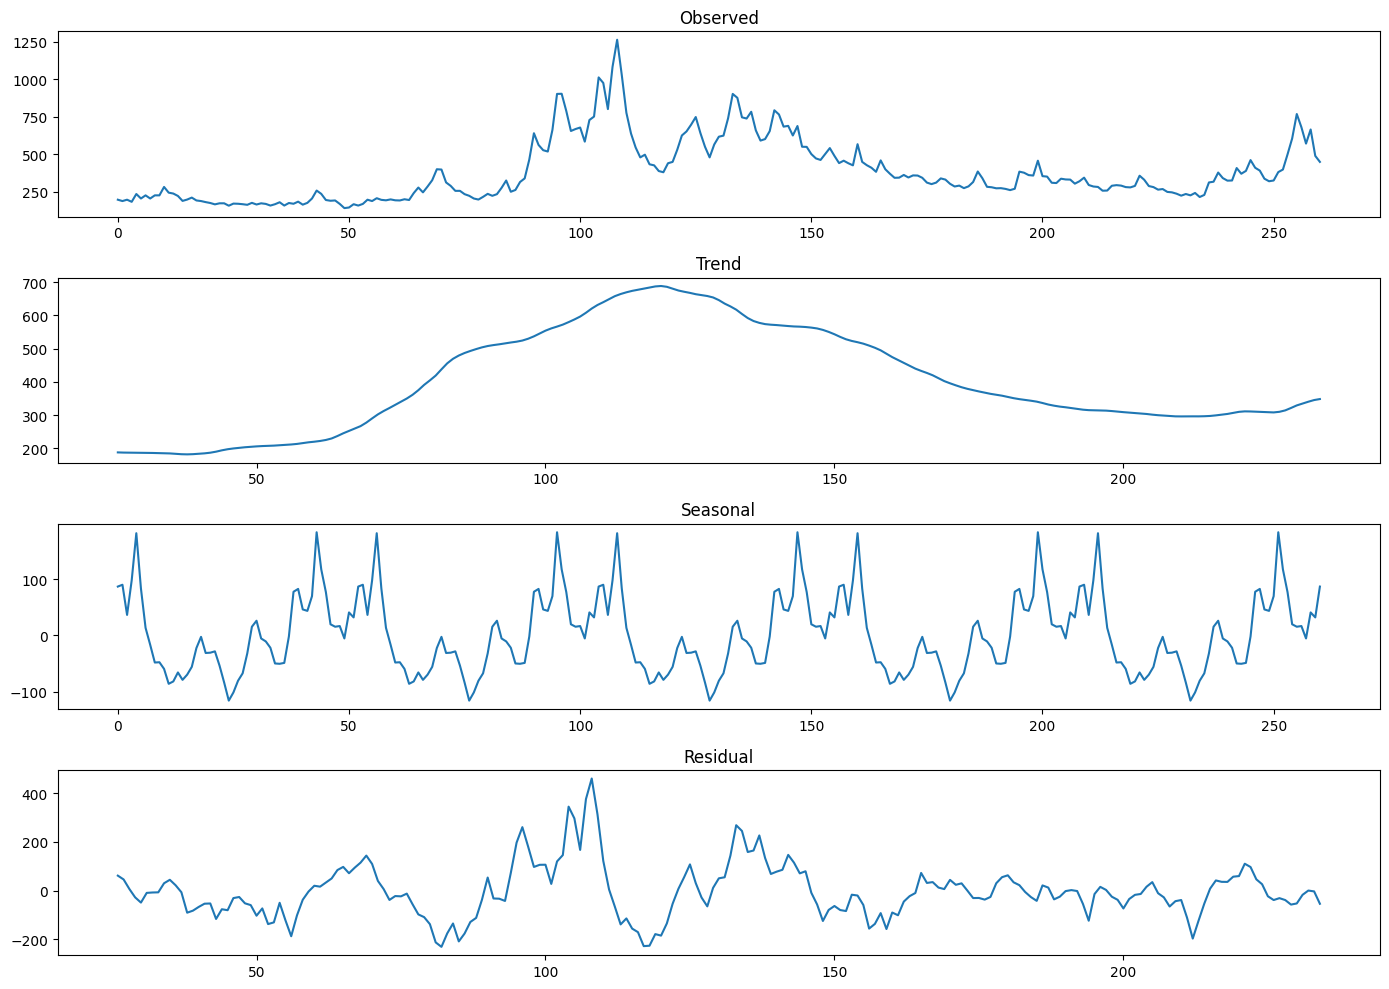

In [ ]:
# Decompose the time series data to find seasonality, trend, and residuals
result = seasonal_decompose(general_trends['Total Search Interest'], model='additive', period=52)  # Weekly data, so period is 52

# Plot the decomposed components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()


# Current Cycle vs Previous Cycles

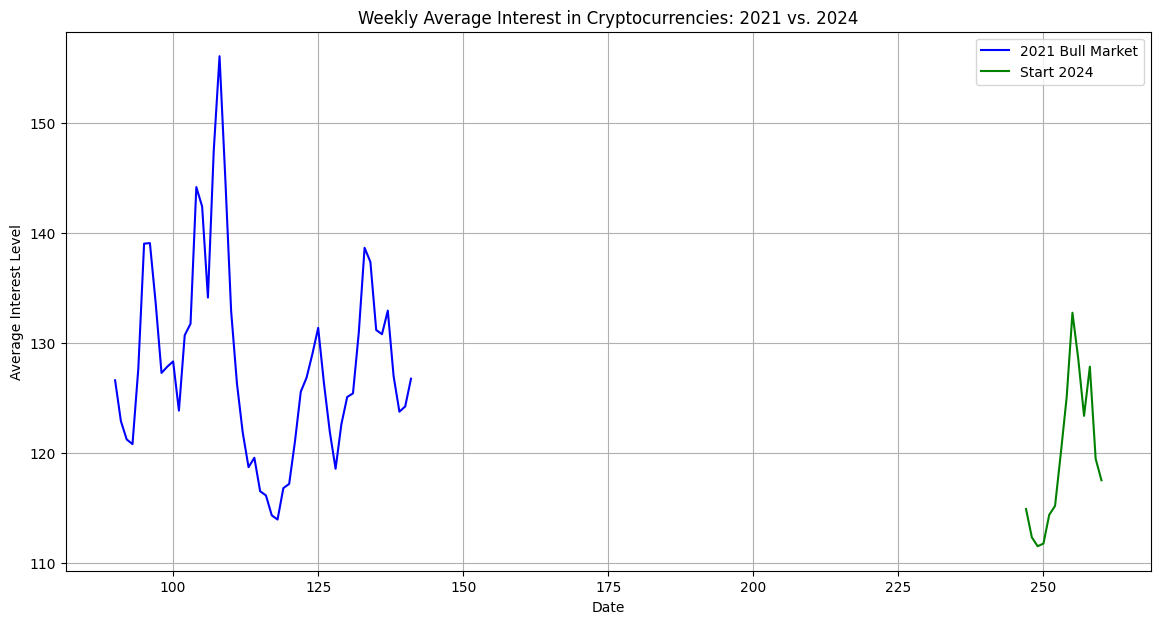

In [ ]:
# Define the date ranges for the analysis
bull_market_2021 = (data['week'] >= '2021-01-01') & (data['week'] <= '2021-12-31')
end_2023_start_2024 = (data['week'] >= '2024-01-01') & (data['week'] <= '2024-04-30')

# Calculate weekly average interest for both periods, dropping any non-numeric columns
weekly_avg_2021 = data[bull_market_2021].drop(columns=['week']).mean(axis=1)
weekly_avg_2023_2024 = data[end_2023_start_2024].drop(columns=['week']).mean(axis=1)

# Plot the weekly average interest
plt.figure(figsize=(14, 7))
plt.plot(weekly_avg_2021.index, weekly_avg_2021, label='2021 Bull Market', color='blue')
plt.plot(weekly_avg_2023_2024.index, weekly_avg_2023_2024, label='Start 2024', color='green')
plt.title('Weekly Average Interest in Cryptocurrencies: 2021 vs. 2024')
plt.xlabel('Date')
plt.ylabel('Average Interest Level')
plt.legend()
plt.grid(True)
plt.show()


# Correlation: Token Price vs Trends

{'ADA': 0.8350122749153425, 'AGIX': 0.620477387850801, 'BNB': 0.496056335831621, 'BTC': 0.6406610216067893, 'CAKE': 0.8331478623208322, 'DOGE': 0.5111917223257191, 'DOT': 0.7979210462605036, 'ETH': 0.661207922867906, 'FET': 0.7318965951646382, 'FIL': 0.619406908291012, 'KCS': 0.8702057114317888, 'LINK': 0.6637346085843997, 'LTC': 0.7609614289365915, 'OCEAN': 0.7397275179805359, 'ROSE': 0.7594340979416333, 'SOL': 0.8225340185660258, 'UNI': 0.7951977951402753, 'XMR': 0.714337605428412, 'XRP': 0.5517726969199871, 'XTZ': 0.7710027063763106}


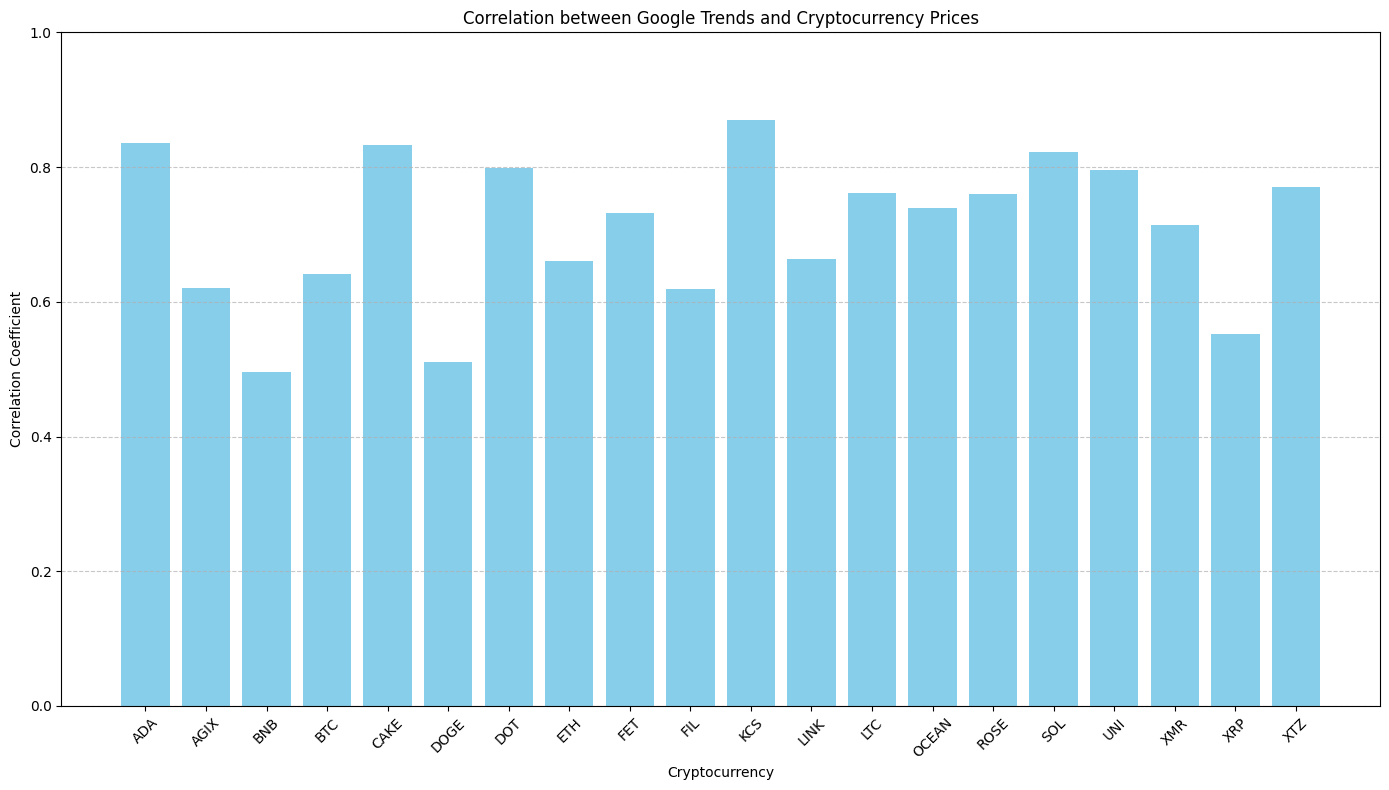

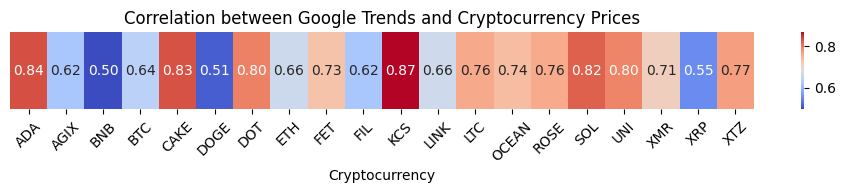

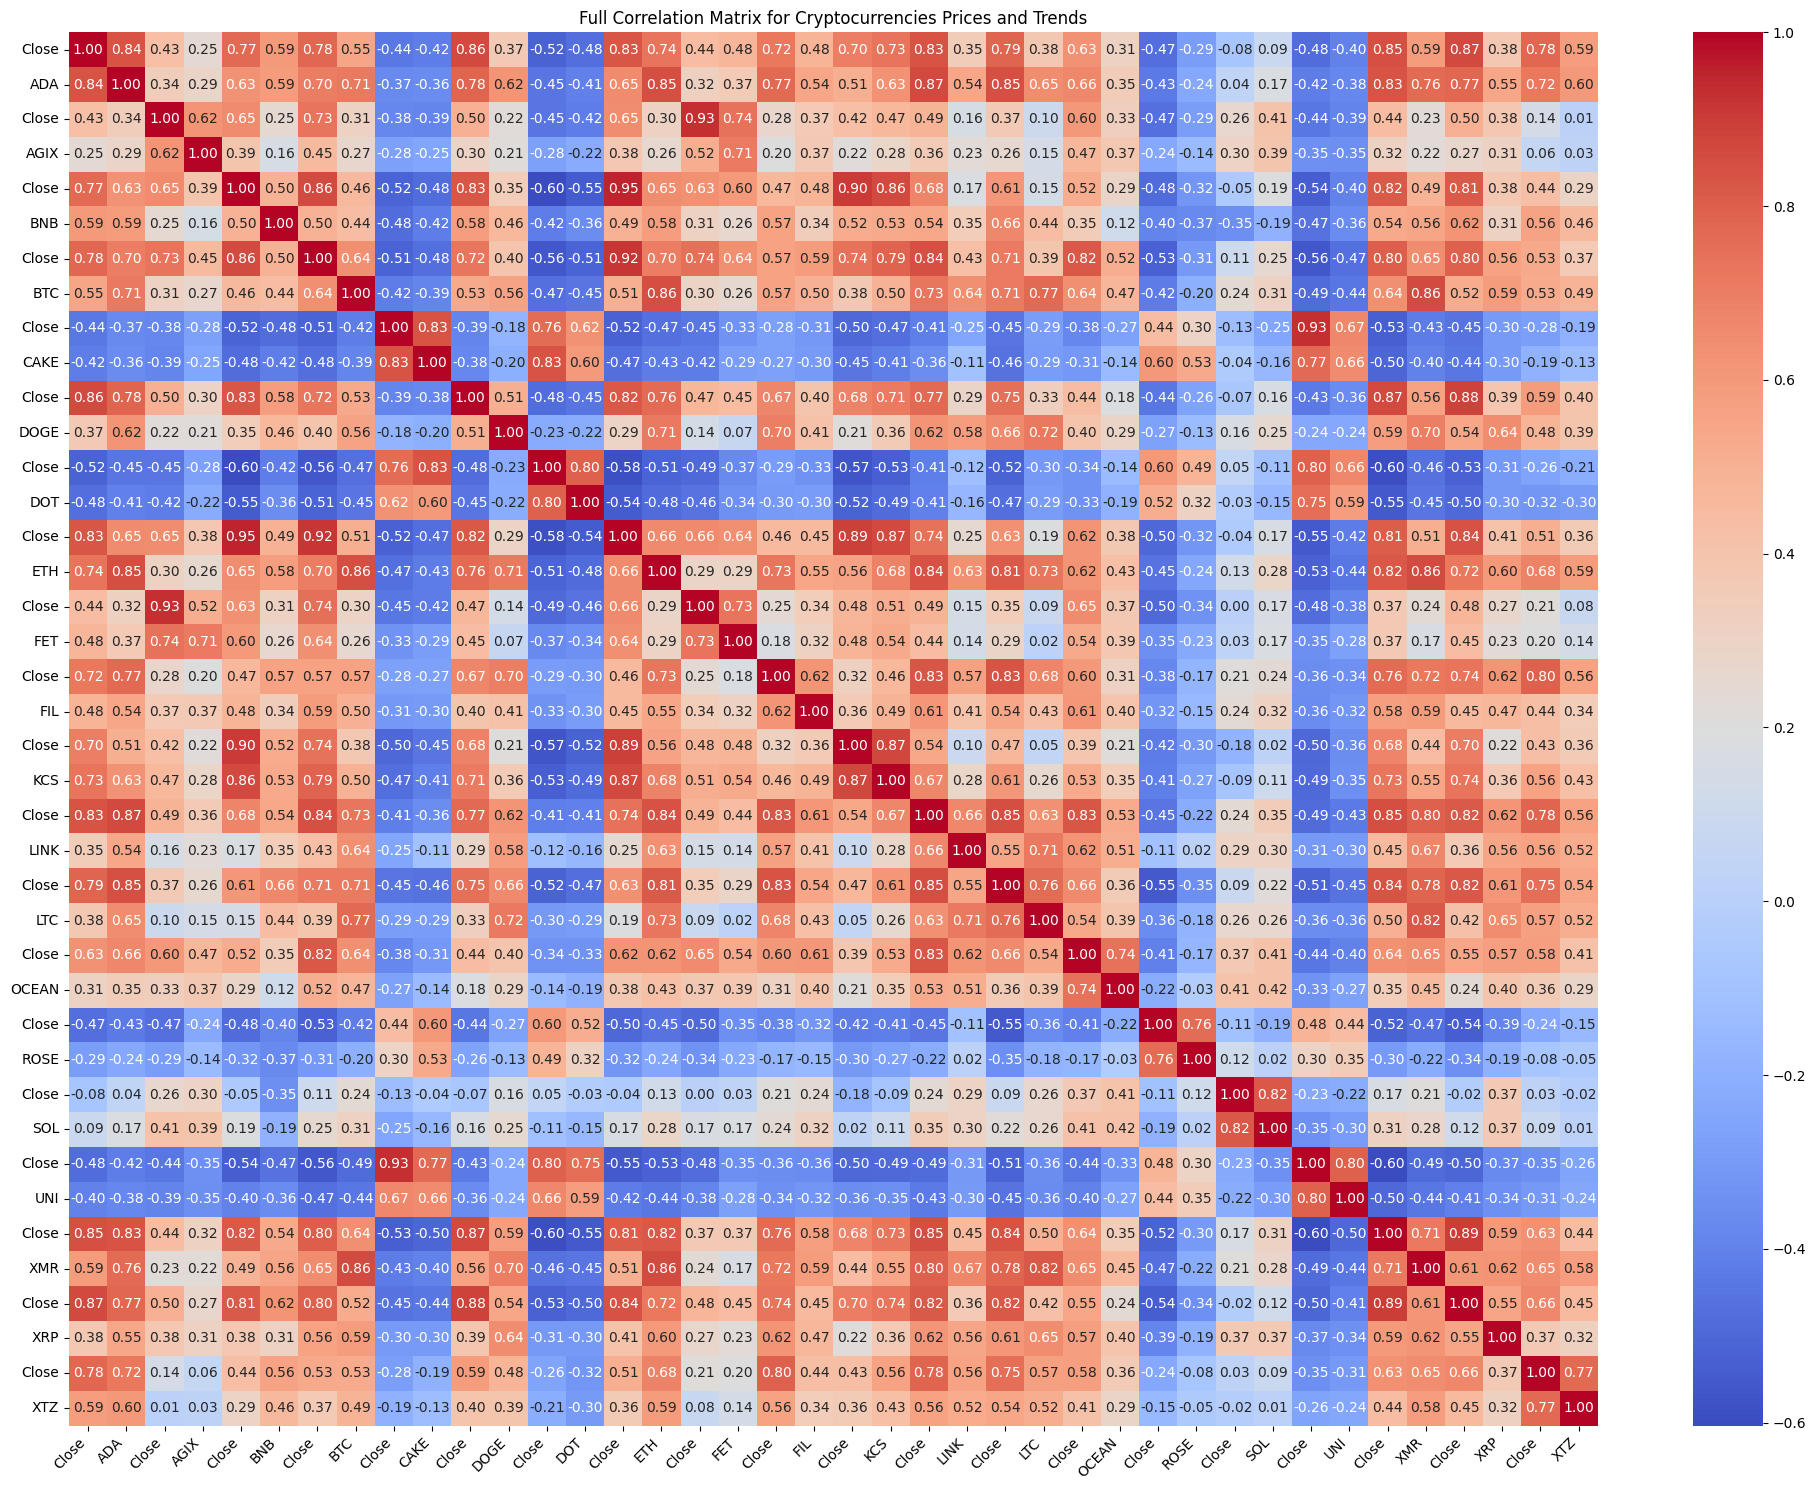

In [ ]:
prices_path = "prices.csv"
trends_path = "trends.csv"

prices_data = pd.read_csv(prices_path)
trends_data = pd.read_csv(trends_path)

# Define the mapping from abbreviations to full names in the Google Trends dataset
crypto_mapping = {
    "ADA": "cardano",
    "AGIX": "singularitynet",
    "BNB": "bnb",
    "BTC": "bitcoin",
    "CAKE": "pancakeswap",
    "DOGE": "dogecoin",
    "DOT": "polkadot",
    "ETH": "ethereum",
    "FET": "fetch",
    "FIL": "filecoin",
    "KCS": "kucoin",
    "LINK": "chainlink",
    "LTC": "litecoin",
    "OCEAN": "ocean protocol",
    "ROSE": "oasis network",
    "SOL": "solana",
    "UNI": "uniswap",
    "XMR": "monero",
    "XRP": "XRP",
    "XTZ": "tezos"
}


trends_data_renamed = trends_data.rename(columns={v: k for k, v in crypto_mapping.items() if v in trends_data.columns})

trends_data_renamed['week'] = pd.to_datetime(trends_data_renamed['week'])
prices_data['Date'] = pd.to_datetime(prices_data['Date'])

weekly_prices = prices_data.set_index('Date').groupby('Symbol').resample('W').mean().reset_index()

def calculate_correlations(prices, trends, crypto_symbols):
    correlation_results = {}
    for symbol in crypto_symbols:
        if symbol in trends.columns:  # Ensure the symbol exists in the trends data
            combined_data = prices[prices['Symbol'] == symbol].merge(
                trends[['week', symbol]], left_on='Date', right_on='week', how='inner'
            )
            correlation = combined_data['Close'].corr(combined_data[symbol])
            correlation_results[symbol] = correlation
    return correlation_results

# Calculate correlations for each cryptocurrency using the defined function
crypto_symbols = list(crypto_mapping.keys())  # List of all symbols from the mapping dictionary
correlation_results = calculate_correlations(weekly_prices, trends_data_renamed, crypto_symbols)

# Display the correlation results
print(correlation_results)

# Convert the correlation results to a DataFrame for easier plotting
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Cryptocurrency', 'Correlation'])

# Plotting the correlations
plt.figure(figsize=(14, 8))
plt.bar(correlation_df['Cryptocurrency'], correlation_df['Correlation'], color='skyblue')
plt.xlabel('Cryptocurrency')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between Google Trends and Cryptocurrency Prices')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)  # Correlation values range from -1 to 1, but all positive here
plt.tight_layout()

plt.show()

correlations_data = pd.DataFrame()
for symbol in crypto_mapping.keys():
    if symbol in trends_data_renamed.columns:
        temp_prices = weekly_prices[weekly_prices['Symbol'] == symbol]
        temp_trends = trends_data_renamed[['week', symbol]]
        temp_merged = temp_prices.merge(temp_trends, left_on='Date', right_on='week', how='inner')
        correlation = temp_merged['Close'].corr(temp_merged[symbol])
        correlations_data.loc[symbol, 'Correlation'] = correlation

# Reshape for heatmap
correlations_matrix = correlations_data.T

# Plotting the focused correlation matrix as a heatmap
plt.figure(figsize=(12, 1))
sns.heatmap(correlations_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation between Google Trends and Cryptocurrency Prices')
plt.xlabel('Cryptocurrency')
plt.yticks([])  # No y-axis ticks needed for this single row heatmap
plt.xticks(rotation=45)
plt.show()


# Full heatmap
# Merge all trends and prices data by week and symbol into a single DataFrame for correlation calculation
all_data = pd.DataFrame()
for symbol in crypto_mapping.keys():
    if symbol in trends_data_renamed.columns:
        temp_prices = weekly_prices[weekly_prices['Symbol'] == symbol]
        temp_trends = trends_data_renamed[['week', symbol]]
        temp_merged = temp_prices.merge(temp_trends, left_on='Date', right_on='week', how='inner')
        all_data = pd.concat([all_data, temp_merged[['Close', symbol]]], axis=1)

# Calculate the correlation matrix
correlation_matrix = all_data.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Full Correlation Matrix for Cryptocurrencies Prices and Trends')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Bidirectional link

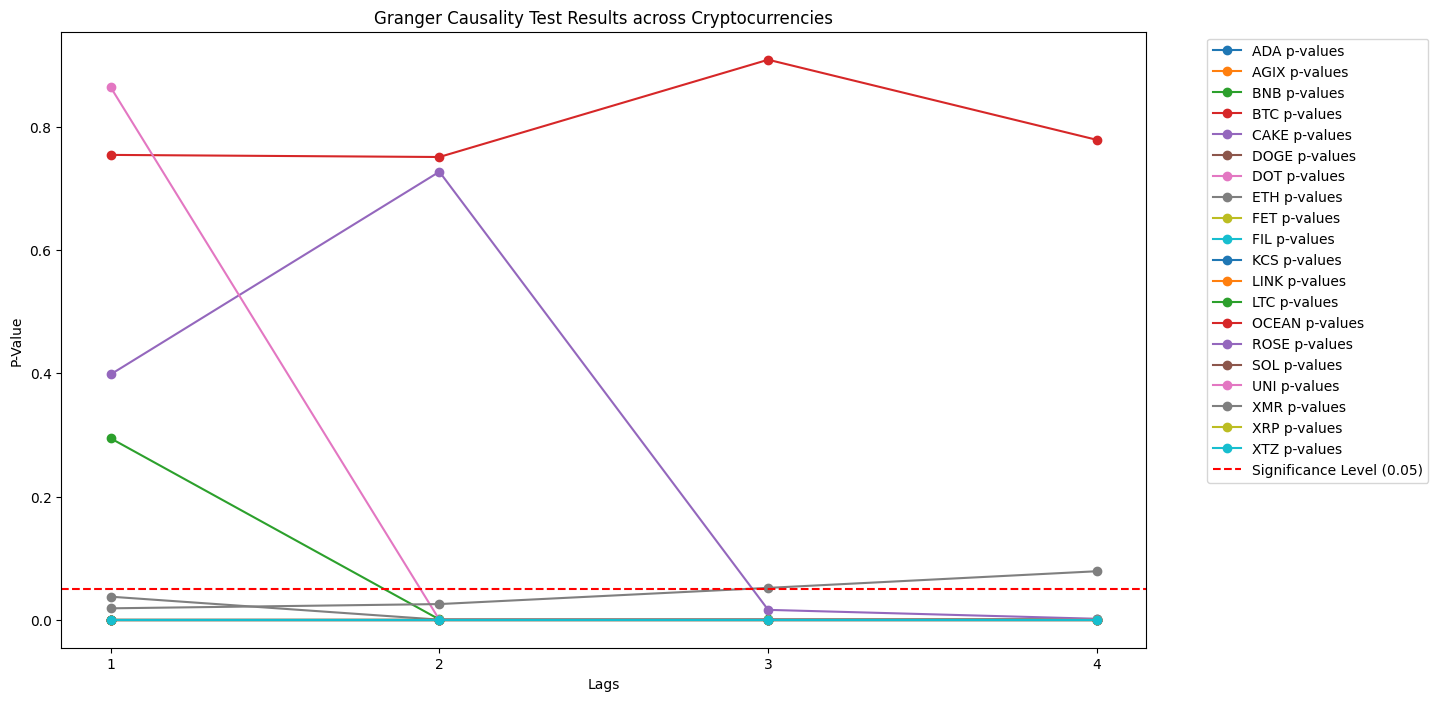

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.stattools import grangercausalitytests


prices_path = "prices.csv"
trends_path = "trends.csv"

trends_data_renamed = trends_data.rename(columns={v: k for k, v in crypto_mapping.items() if v in trends_data.columns})
trends_data_renamed['week'] = pd.to_datetime(trends_data_renamed['week'])
prices_data['Date'] = pd.to_datetime(prices_data['Date'])

weekly_prices = prices_data.set_index('Date').groupby('Symbol').resample('W').mean().reset_index()

# Perform Granger causality tests and store p-values
granger_results = {}
for symbol in crypto_mapping.keys():
    if symbol in trends_data_renamed.columns:
        data = weekly_prices[weekly_prices['Symbol'] == symbol].merge(
            trends_data_renamed[['week', symbol]], left_on='Date', right_on='week', how='inner'
        )[['Close', symbol]].dropna()
        granger_test = grangercausalitytests(data, maxlag=4, verbose=False)
        p_values = [round(granger_test[i+1][0]['ssr_chi2test'][1], 4) for i in range(4)]
        granger_results[symbol] = p_values

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 8))
lags = [1, 2, 3, 4]

# Plot each cryptocurrency's results
for symbol, p_values in granger_results.items():
    ax.plot(lags, p_values, marker='o', label=f'{symbol} p-values')

ax.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
ax.set_xlabel('Lags')
ax.set_ylabel('P-Value')
ax.set_title('Granger Causality Test Results across Cryptocurrencies')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(lags)
plt.show()



# Ideal time lag

{'ADA': {'Lag': 1, 'Correlation': 0.8678515783722632}, 'AGIX': {'Lag': 2, 'Correlation': 0.7519166312150998}, 'BNB': {'Lag': 1, 'Correlation': 0.4992745020860662}, 'BTC': {'Lag': 1, 'Correlation': 0.6359035778417862}, 'CAKE': {'Lag': 1, 'Correlation': 0.8010612757449497}, 'DOGE': {'Lag': 4, 'Correlation': 0.6056778383068476}, 'DOT': {'Lag': 1, 'Correlation': 0.841244375167778}, 'ETH': {'Lag': 1, 'Correlation': 0.6722514385601811}, 'FET': {'Lag': 2, 'Correlation': 0.8480614191250593}, 'FIL': {'Lag': 1, 'Correlation': 0.7134525825786637}, 'KCS': {'Lag': 2, 'Correlation': 0.8851639104966292}, 'LINK': {'Lag': 1, 'Correlation': 0.717640734984578}, 'LTC': {'Lag': 1, 'Correlation': 0.7994190307213844}, 'OCEAN': {'Lag': 1, 'Correlation': 0.8111830774775185}, 'ROSE': {'Lag': 1, 'Correlation': 0.8218108635507837}, 'SOL': {'Lag': 1, 'Correlation': 0.8435602382986525}, 'UNI': {'Lag': 1, 'Correlation': 0.777183313690973}, 'XMR': {'Lag': 1, 'Correlation': 0.7175252006245615}, 'XRP': {'Lag': 1, 'Corr

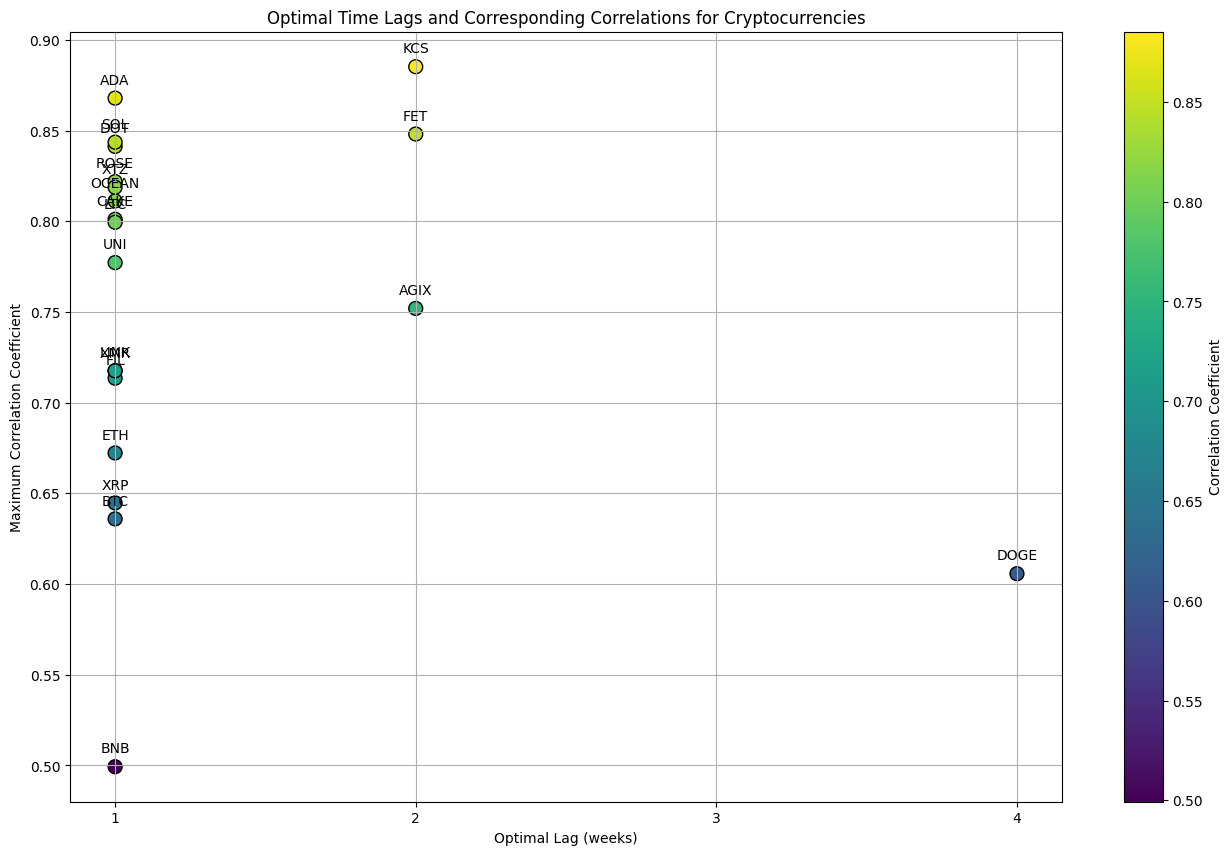

In [ ]:
# Adjust the trends_data to use the symbol as the column name
trends_data_renamed = trends_data.rename(columns={v: k for k, v in crypto_mapping.items() if v in trends_data.columns})
trends_data_renamed['week'] = pd.to_datetime(trends_data_renamed['week'])
prices_data['Date'] = pd.to_datetime(prices_data['Date'])

# Resample prices_data to weekly, by taking the mean of each week's data, grouped by 'Symbol'
weekly_prices = prices_data.set_index('Date').groupby('Symbol').resample('W').mean().reset_index()

optimal_lags = {}

# Exploring lags from 1 to 4 weeks for each cryptocurrency
for symbol in crypto_mapping.keys():
    if symbol in trends_data_renamed.columns:
        # Prepare the data for this cryptocurrency
        merged_data = weekly_prices[weekly_prices['Symbol'] == symbol].merge(
            trends_data_renamed[['week', symbol]], left_on='Date', right_on='week', how='inner'
        )[['Close', symbol]].dropna()

        # Check up to 4 weeks lag
        max_correlation = -1  # Initialize with a minimum correlation value
        best_lag = 0
        for lag in range(1, 5):
            # Create lagged version of the Google Trends data
            merged_data['Trend_Lagged'] = merged_data[symbol].shift(lag)
            correlation = merged_data['Close'].corr(merged_data['Trend_Lagged'])
            if not np.isnan(correlation) and correlation > max_correlation:
                max_correlation = correlation
                best_lag = lag

        # Store the best lag and its correlation for this cryptocurrency
        optimal_lags[symbol] = {'Lag': best_lag, 'Correlation': max_correlation}

print(optimal_lags)

# Plotting the optimal lags and their corresponding correlations
fig, ax = plt.subplots(figsize=(16, 10))
symbols = list(optimal_lags.keys())
correlations = [optimal_lags[symbol]['Correlation'] for symbol in symbols]
lags = [optimal_lags[symbol]['Lag'] for symbol in symbols]

# Create scatter plot with annotations
scatter = ax.scatter(lags, correlations, c=correlations, cmap='viridis', s=100, edgecolor='k')
plt.colorbar(scatter, label='Correlation Coefficient')
ax.set_xlabel('Optimal Lag (weeks)')
ax.set_ylabel('Maximum Correlation Coefficient')
ax.set_title('Optimal Time Lags and Corresponding Correlations for Cryptocurrencies')
ax.set_xticks([1, 2, 3, 4])

# Annotate points
for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (lags[i], correlations[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()


# Trends - Correlation

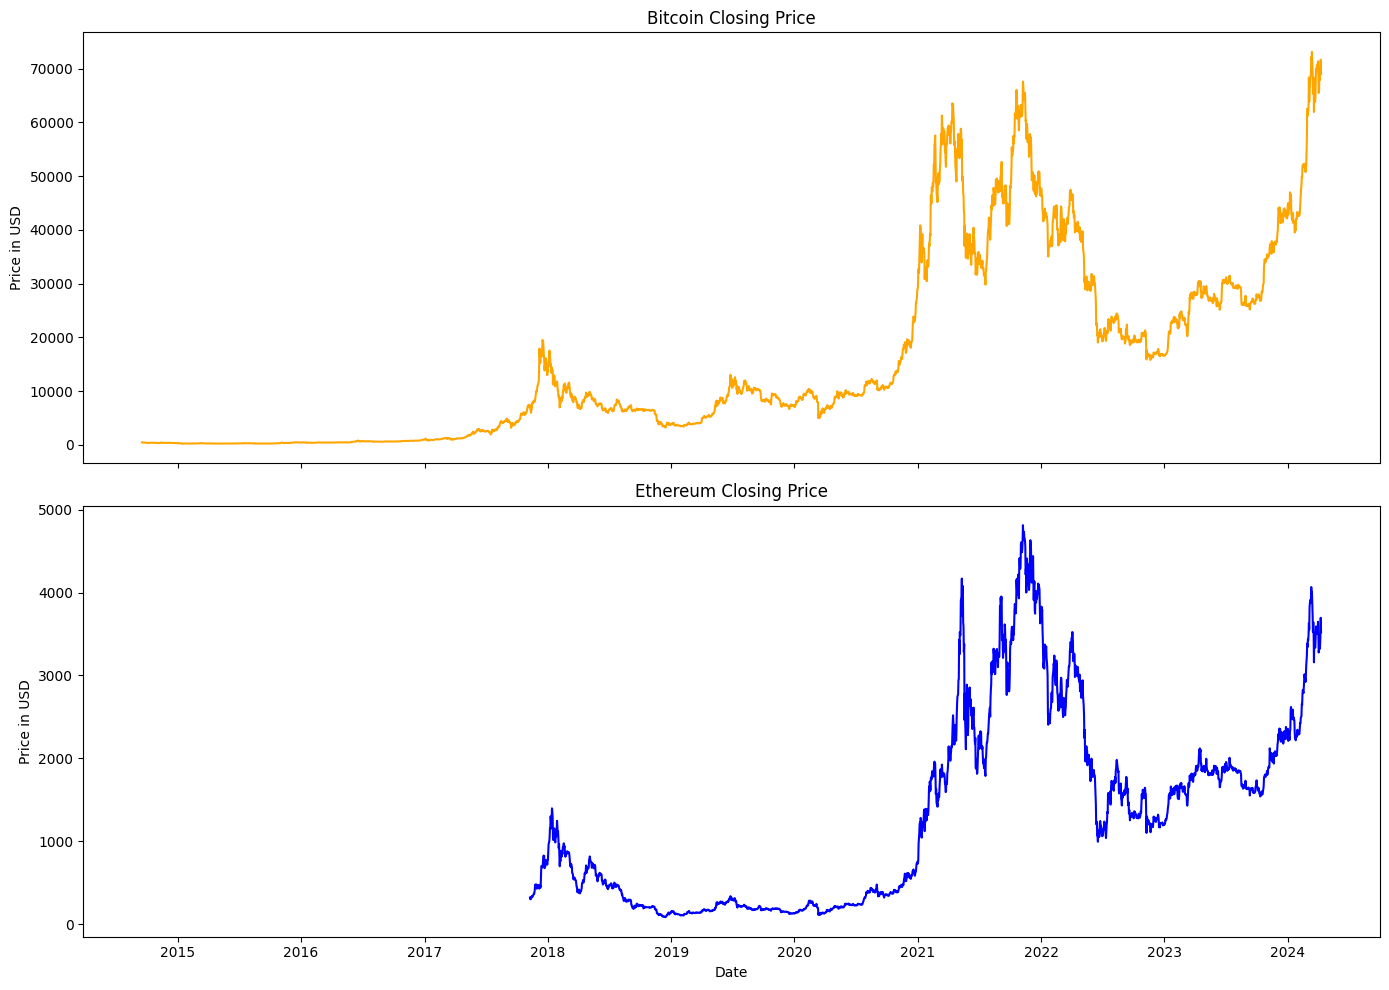

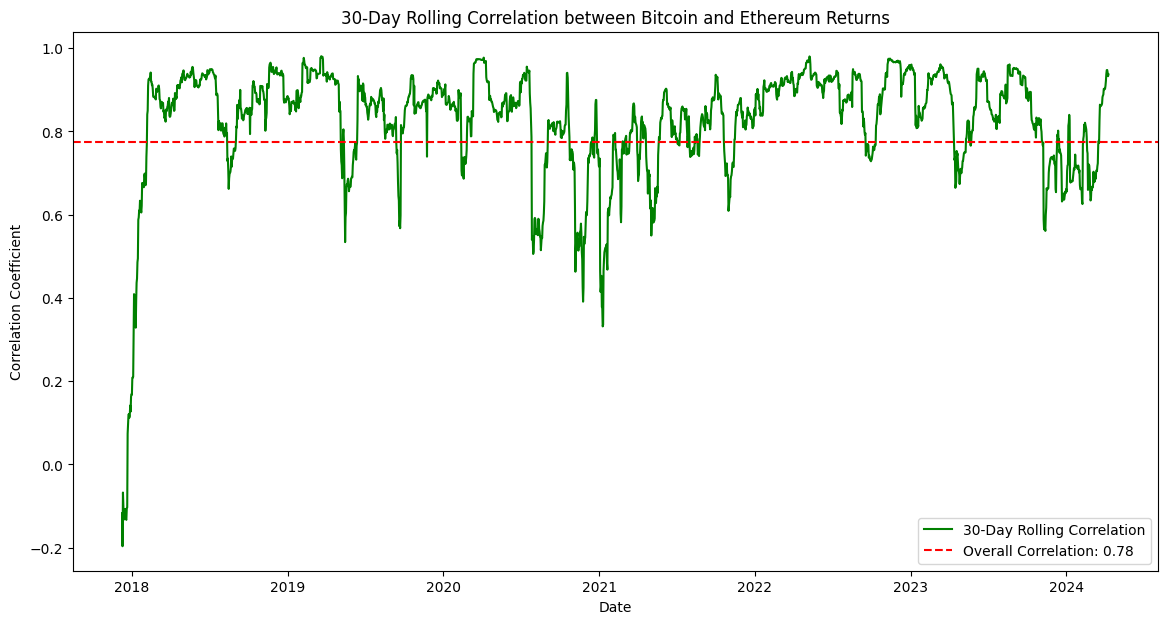

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
btc_eth_data = pd.read_csv('prices.csv')

# Filter for Bitcoin and Ethereum
btc_data = btc_eth_data[btc_eth_data['Symbol'] == 'BTC']
eth_data = btc_eth_data[btc_eth_data['Symbol'] == 'ETH']

btc_data['Date'] = pd.to_datetime(btc_data['Date'])
eth_data['Date'] = pd.to_datetime(eth_data['Date'])

btc_data['Returns'] = btc_data['Close'].pct_change()
eth_data['Returns'] = eth_data['Close'].pct_change()

# Align data for correlation calculation
combined_returns = pd.merge(btc_data[['Date', 'Returns']], eth_data[['Date', 'Returns']], on='Date', suffixes=('_btc', '_eth'))

# Calculate the correlation between daily returns
correlation = combined_returns['Returns_btc'].corr(combined_returns['Returns_eth'])

# Calculate 30-day rolling correlation
combined_returns['Rolling_Correlation'] = combined_returns['Returns_btc'].rolling(window=30).corr(combined_returns['Returns_eth'])

# Plotting closing prices
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(btc_data['Date'], btc_data['Close'], label='Bitcoin', color='orange')
ax[0].set_title('Bitcoin Closing Price')
ax[0].set_ylabel('Price in USD')
ax[1].plot(eth_data['Date'], eth_data['Close'], label='Ethereum', color='blue')
ax[1].set_title('Ethereum Closing Price')
ax[1].set_ylabel('Price in USD')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Plotting rolling correlation
plt.figure(figsize=(14, 7))
plt.plot(combined_returns['Date'], combined_returns['Rolling_Correlation'], label='30-Day Rolling Correlation', color='green')
plt.title('30-Day Rolling Correlation between Bitcoin and Ethereum Returns')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=correlation, color='red', linestyle='--', label=f'Overall Correlation: {correlation:.2f}')
plt.legend()
plt.show()


# BTC Insights

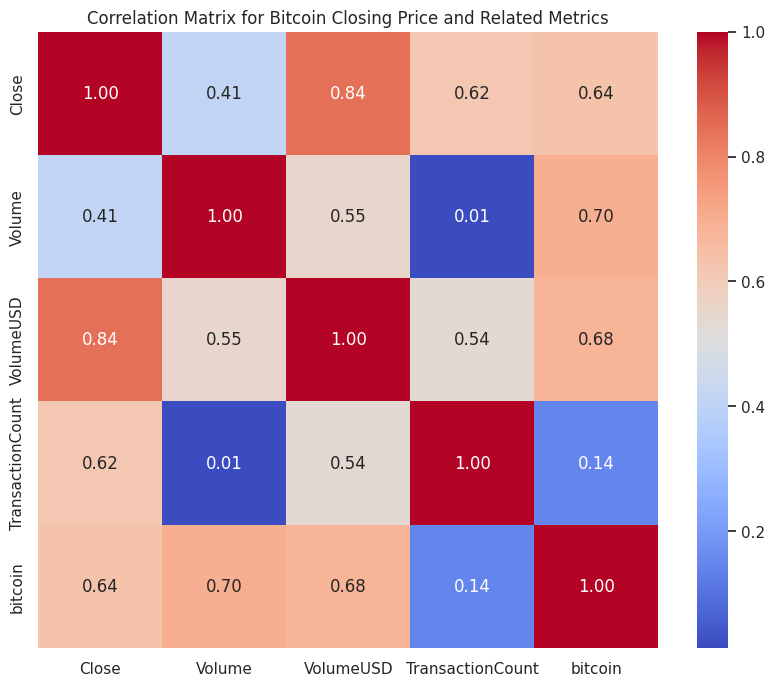

In [ ]:
# Load the datasets
prices_df = pd.read_csv('prices.csv')
transaction_info_df = pd.read_csv('transactions.csv')
trends_df = pd.read_csv('trends.csv')

# Prepare the datasets
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
transaction_info_df.columns = transaction_info_df.columns.str.strip()
transaction_info_df = transaction_info_df.rename(columns={'Timestamp': 'Date', 'TransactionVolumeUSD': 'VolumeUSD', 'TransactionCount': 'TransactionCount'})
transaction_info_df['Date'] = pd.to_datetime(transaction_info_df['Date'])
trends_df['week'] = pd.to_datetime(trends_df['week'])

# Filter Bitcoin data
bitcoin_prices = prices_df[prices_df['Symbol'] == 'BTC']
bitcoin_trends = trends_df[['week', 'bitcoin']]
bitcoin_transactions = transaction_info_df

# Resample to weekly
weekly_prices = bitcoin_prices.resample('W-Sun', on='Date').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Adj Close': 'last', 'Volume': 'sum'})
weekly_transactions = bitcoin_transactions.resample('W-Sun', on='Date').agg({'VolumeUSD': 'sum', 'TransactionCount': 'sum'})

# Merge datasets
merged_data = weekly_prices.merge(weekly_transactions, left_index=True, right_index=True, how='outer')
merged_data = merged_data.merge(bitcoin_trends, left_index=True, right_on='week', how='outer')

# Filter data from 2019 onward
filtered_data = merged_data[merged_data['week'] >= '2019-01-01']

# Calculate correlations
close_price_correlation = filtered_data[['Close', 'Volume', 'VolumeUSD', 'TransactionCount', 'bitcoin']].corr()

# Plotting
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(close_price_correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Bitcoin Closing Price and Related Metrics')
plt.show()


# Bitcoin & ETH - Tokens correlations

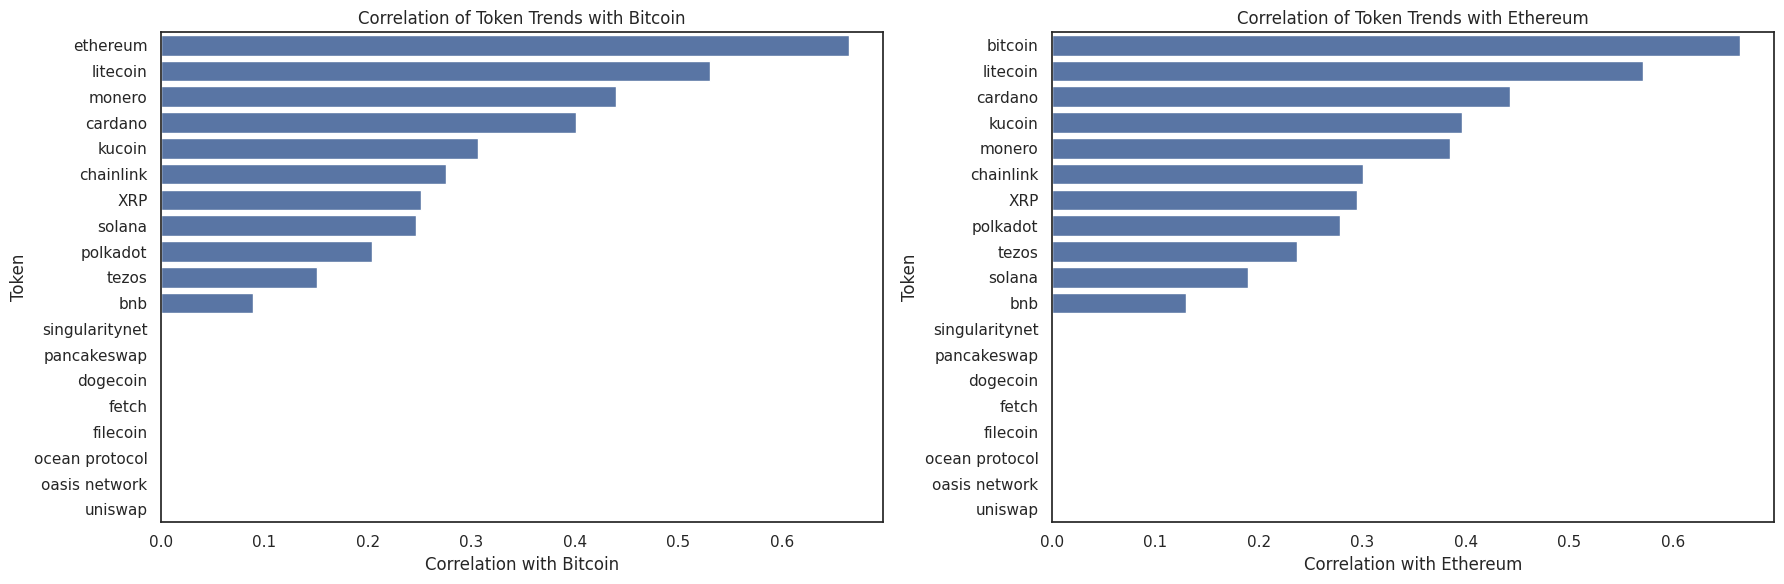

In [ ]:
bitcoin_prices_weekly = prices_df[prices_df['Symbol'] == 'BTC'].resample('W-Sun', on='Date').last()
ethereum_prices_weekly = prices_df[prices_df['Symbol'] == 'ETH'].resample('W-Sun', on='Date').last()
bitcoin_price_changes = bitcoin_prices_weekly['Close'].pct_change().dropna()
ethereum_price_changes = ethereum_prices_weekly['Close'].pct_change().dropna()

cleaned_trends_df = trends_df.set_index('week').apply(pd.to_numeric, errors='coerce')
bitcoin_trend_changes = cleaned_trends_df['bitcoin'].pct_change().dropna()
ethereum_trend_changes = cleaned_trends_df['ethereum'].pct_change().dropna()

# Calculate correlations for other tokens
other_token_price_changes = {}
other_token_trend_changes = {}
for symbol, trend_name in crypto_mapping.items():
    if symbol in prices_df['Symbol'].unique() and trend_name in trends_df.columns:
        token_prices_weekly = prices_df[prices_df['Symbol'] == symbol].resample('W-Sun', on='Date').last()
        other_token_price_changes[symbol] = token_prices_weekly['Close'].pct_change().dropna()
        token_trends_weekly = cleaned_trends_df[trend_name]
        other_token_trend_changes[trend_name] = token_trends_weekly.pct_change().dropna()

# Calculate and plot correlations
bitcoin_trend_correlations = {trend: bitcoin_trend_changes.corr(changes) for trend, changes in other_token_trend_changes.items() if trend != 'bitcoin'}
ethereum_trend_correlations = {trend: ethereum_trend_changes.corr(changes) for trend, changes in other_token_trend_changes.items() if trend != 'ethereum'}
bitcoin_trend_correlation_df = pd.DataFrame(list(bitcoin_trend_correlations.items()), columns=['Token', 'Correlation with Bitcoin'])
ethereum_trend_correlation_df = pd.DataFrame(list(ethereum_trend_correlations.items()), columns=['Token', 'Correlation with Ethereum'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x='Correlation with Bitcoin', y='Token', data=bitcoin_trend_correlation_df.sort_values('Correlation with Bitcoin', ascending=False), ax=ax1)
ax1.set_title('Correlation of Token Trends with Bitcoin')
sns.barplot(x='Correlation with Ethereum', y='Token', data=ethereum_trend_correlation_df.sort_values('Correlation with Ethereum', ascending=False), ax=ax2)
ax2.set_title('Correlation of Token Trends with Ethereum')
plt.tight_layout()
plt.show()


# General correlations

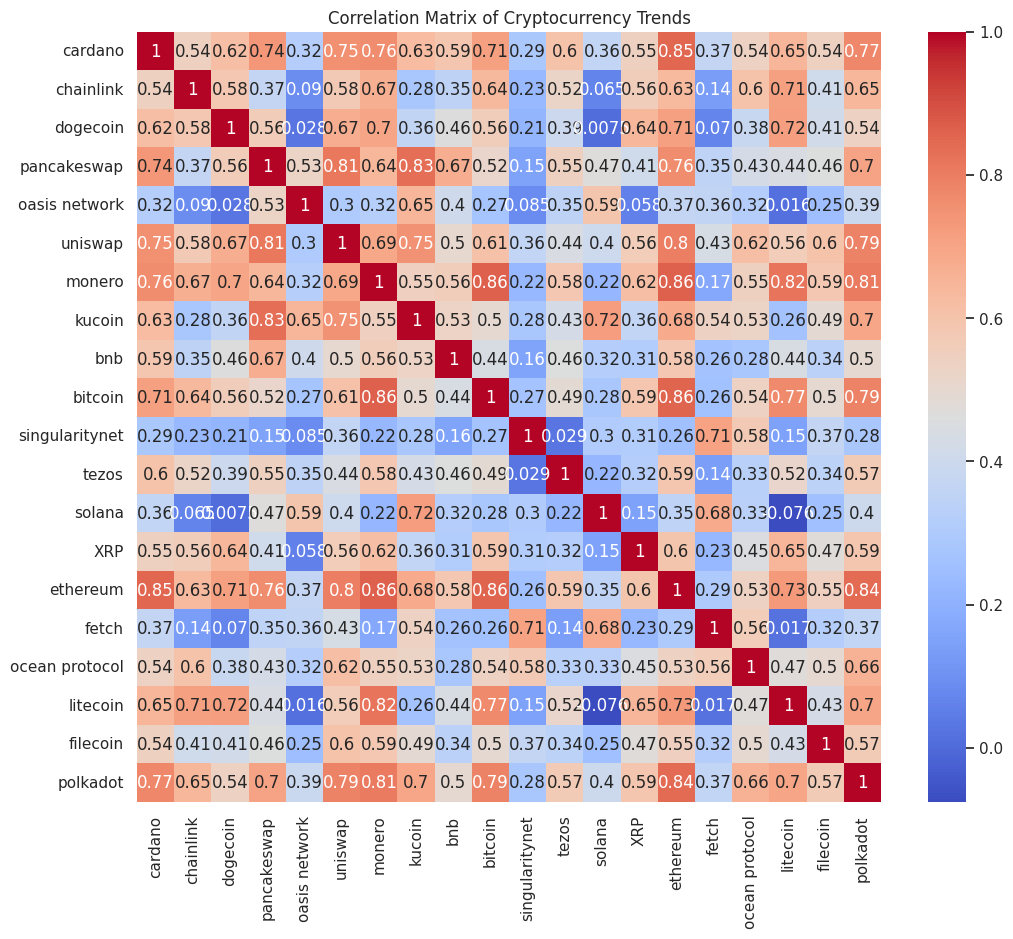

Ethereum and Monero Correlation: 0.8617945560555792
Ocean Protocol Correlation: ocean protocol    1.000000
polkadot          0.660569
uniswap           0.620556
chainlink         0.603204
singularitynet    0.575918
fetch             0.559337
monero            0.545805
cardano           0.541248
bitcoin           0.538370
ethereum          0.533620
kucoin            0.528430
filecoin          0.499062
litecoin          0.474566
XRP               0.450783
pancakeswap       0.427485
dogecoin          0.380809
solana            0.332909
tezos             0.330418
oasis network     0.318529
bnb               0.279532
Name: ocean protocol, dtype: float64


In [ ]:
# Calculate the correlation matrix for the cleaned trends data
token_trend_correlation_matrix = cleaned_trends_df.corr()

# Plot the full correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(token_trend_correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Cryptocurrency Trends')
plt.show()

# Calculate and display specific correlations of interest
ethereum_monero_correlation = token_trend_correlation_matrix.loc['ethereum', 'monero']
ocean_correlation = token_trend_correlation_matrix.loc['ocean protocol'].sort_values(ascending=False)

print(f"Ethereum and Monero Correlation: {ethereum_monero_correlation}")
print(f"Ocean Protocol Correlation: {ocean_correlation}")


# Additional dataset

In [83]:
from datetime import datetime
data1 = pd.read_csv('transactions/transaction-volume-usd.csv')
data2 = pd.read_csv('transactions/transactions-count.csv')

def process_data(data):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='ms')
    data.set_index('Timestamp', inplace=True)
    weekly_data = data.resample('W').mean()
    start_date = datetime(2017, 1, 1)
    end_date = datetime.now()
    weekly_data = weekly_data[(weekly_data.index >= start_date) & (weekly_data.index <= end_date)]
    weekly_data.reset_index(inplace=True)
    return weekly_data

weekly_data1 = process_data(data1)
weekly_data2 = process_data(data2)

merged_weekly_data = pd.merge(weekly_data1, weekly_data2, on='Timestamp', how='outer')

merged_weekly_data.to_csv('transactions.csv', index=False)
merged_weekly_data.head()

,Timestamp,TransactionVolumeUSD,TransactionCount
0,2017-01-01,2.420807e+08,182941295.0
1,2017-01-08,3.646330e+08,184567133.5
2,2017-01-15,2.672544e+08,186928872.0
3,2017-01-22,2.170041e+08,189143016.0
4,2017-01-29,1.894567e+08,190780358.0


# Trend - prediction

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbn2kw6jw/fta22io9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbn2kw6jw/ceo_9yad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9106', 'data', 'file=/tmp/tmpbn2kw6jw/fta22io9.json', 'init=/tmp/tmpbn2kw6jw/ceo_9yad.json', 'output', 'file=/tmp/tmpbn2kw6jw/prophet_modelvmd0ezfg/prophet_model-20240430100527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


2/2 [==============================] - 0s 8ms/step
ARIMA Evaluation Metrics:
MAE: 3.5333198579440164
MSE: 28.466319795286324
RMSE: 5.335383753328932

SARIMA Evaluation Metrics:
MAE: 6.077230779590015
MSE: 69.83912078009357
RMSE: 8.356980362552827

Prophet Evaluation Metrics:
MAE: 6.514129168564586
MSE: 63.85613285309071
RMSE: 7.991003244467538

LSTM Evaluation Metrics:
MAE: 23.83033546920895
MSE: 605.8295301360845
RMSE: 24.61360457422042


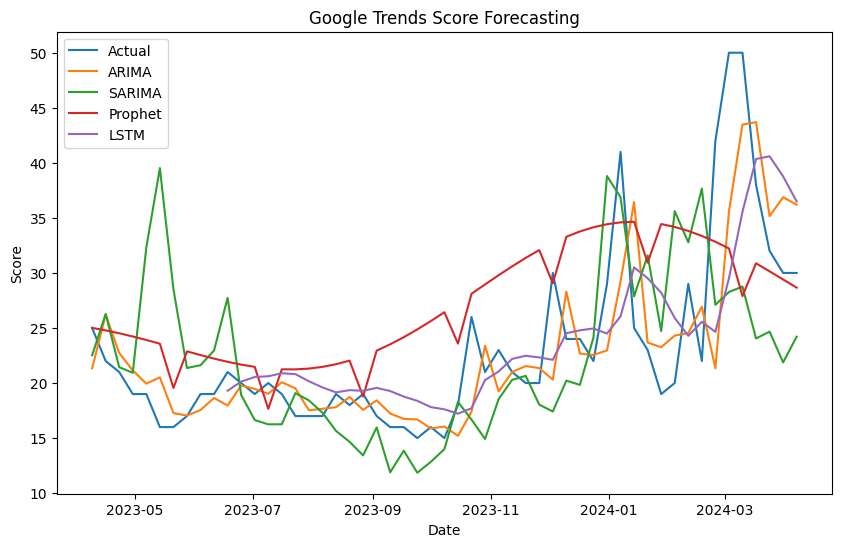

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignore specific warning types
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters for seasonal ARMA")


df = pd.read_csv('trends/bitcoin.csv', skiprows=3, names=['week', 'score'])
df['week'] = pd.to_datetime(df['week'])
df.set_index('week', inplace=True)

# Split data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Function to calculate evaluation metrics
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# ARIMA model
def arima_forecast(train, test):
    history = train['score'].values.tolist()
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test['score'].iloc[t])
    return predictions

# SARIMA model
def sarima_forecast(train, test):
    model = SARIMAX(train['score'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test))
    return predictions

# Prophet model
def prophet_forecast(train, test):
    prophet_model = Prophet(weekly_seasonality=True)

    prophet_model.fit(train.reset_index().rename(columns={'week':'ds', 'score':'y'}))
    future = prophet_model.make_future_dataframe(periods=len(test))
    forecast = prophet_model.predict(future)
    return forecast[-len(test):]['yhat'].values

def lstm_forecast(train, test):
    # Scale data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)

    # Prepare data for LSTM
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X[i:(i + time_steps)]
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10
    X_train, y_train = create_dataset(scaled_train, scaled_train[:, 0], time_steps)
    X_test, y_test = create_dataset(scaled_test, scaled_test[:, 0], time_steps)

    # Define LSTM model
    model = Sequential([
        LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train LSTM model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Reshape for inverse_transform

    return y_pred.flatten(), y_test  # Return both predictions and actual test values that have corresponding predictions

# Perform forecasts
arima_preds = arima_forecast(train, test)
sarima_preds = sarima_forecast(train, test)
prophet_preds = prophet_forecast(train, test)
lstm_preds, y_lstm_test = lstm_forecast(train.values, test.values)

# Evaluate forecasts
arima_mae, arima_mse, arima_rmse = evaluate_forecast(test['score'].values, arima_preds)
sarima_mae, sarima_mse, sarima_rmse = evaluate_forecast(test['score'].values, sarima_preds)
prophet_mae, prophet_mse, prophet_rmse = evaluate_forecast(test['score'].values, prophet_preds)
lstm_mae, lstm_mse, lstm_rmse = evaluate_forecast(y_lstm_test, lstm_preds)

print("ARIMA Evaluation Metrics:")
print("MAE:", arima_mae)
print("MSE:", arima_mse)
print("RMSE:", arima_rmse)
print("\nSARIMA Evaluation Metrics:")
print("MAE:", sarima_mae)
print("MSE:", sarima_mse)
print("RMSE:", sarima_rmse)
print("\nProphet Evaluation Metrics:")
print("MAE:", prophet_mae)
print("MSE:", prophet_mse)
print("RMSE:", prophet_rmse)
print("\nLSTM Evaluation Metrics:")
print("MAE:", lstm_mae)
print("MSE:", lstm_mse)
print("RMSE:", lstm_rmse)

time_steps = 10
adjusted_test_index = test.index[time_steps:]

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['score'], label='Actual')
plt.plot(test.index, arima_preds, label='ARIMA')
plt.plot(test.index, sarima_preds, label='SARIMA')
plt.plot(test.index, prophet_preds, label='Prophet')
plt.plot(adjusted_test_index, lstm_preds, label='LSTM')  # Use the adjusted index for LSTM
plt.legend()
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Google Trends Score Forecasting')
plt.show()
